In [64]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
with open('data/full_data_corrected_2024.pkl', 'rb') as file:
    small_data = pickle.load(file)

In [66]:
# Choose an index to inspect (the first sample)
i = 0

# Print out all values for that sample
for key in small_data.keys():
    value = small_data[key][i]
    print(f"{key}: {value}")

I: [-0.018 -0.021 -0.018 ...  0.036  0.03   0.024]
II: [-0.042 -0.039 -0.036 ...  0.084  0.087  0.09 ]
III: [-0.021 -0.018 -0.018 ...  0.048  0.057  0.066]
AVR: [ 0.     0.     0.    ... -0.006 -0.012 -0.018]
AVL: [ 0.03   0.03   0.03  ... -0.063 -0.06  -0.06 ]
AVF: [-0.033 -0.03  -0.027 ...  0.066  0.072  0.078]
V1: [ 0.018  0.018  0.021 ... -0.048 -0.045 -0.042]
V2: [-0.06  -0.057 -0.054 ...  0.042  0.045  0.048]
V3: [-0.06  -0.06  -0.057 ...  0.057  0.06   0.057]
V4: [-0.093 -0.09  -0.087 ...  0.168  0.168  0.171]
V5: [-0.093 -0.09  -0.09  ...  0.159  0.156  0.159]
V6: [-0.075 -0.072 -0.072 ...  0.102  0.102  0.108]
Sex: Female
HTA: nan
Age: 61.0
PVC_transition: V1
SOO_chamber: Right ventricle
Height: nan
Weight: nan
BMI: nan
DM: nan
DLP: nan
Smoker: nan
COPD: nan
Sleep_apnea: nan
CLINICAL_SCORE: nan
SOO: Unión mitroaórtica
OTorigin: 0.0


This is a full ECG record, including:
* Raw 12-lead signals, each one a NumPy array
* Patient metadata: Sex, HTA, PVC_transition, SOO_chamber, Height, Weight, BMI, DM, DLP, Smoker, COPD, Sleep_apnea, CLINICAL_SCORE, SOO, OTorigin.

In [67]:
# Convert to a dataframe for easier manipulation
metadata_keys = ['Sex', 'HTA', 'Age', 'PVC_transition', 'SOO_chamber', 'Height', 'Weight', 'BMI', 
                 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'SOO', 'OTorigin']

df_small_meta = pd.DataFrame({key: small_data[key] for key in metadata_keys})

df_small_meta.head(10)

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
0,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0
1,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,No,No,No,No,1.0,Pared libre anterior,1.0
2,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,No,No,No,1.0,RCC,1.0
3,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,No,No,No,1.0,M. papilar posteromedial,0.0
4,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,No,No,No,1.0,RVOT septal,1.0
5,Male,No,84.0,V3,LVOT,179.0,97.0,30.273712,No,No,No,Yes,No,2.0,Seno de Valsalva izdo.,1.0
6,Male,Yes,74.0,V2,LVOT,167.0,89.0,31.912223,No,Yes,No,No,No,3.0,Intersenos dcho.-izdo.,1.0
7,Male,Yes,72.0,V2,LVOT,NaN,NaN,NaN,No,Yes,No,No,No,3.0,LVOT intersenos dcho.-izdo.,1.0
8,Female,Yes,62.0,V3,RVOT,152.0,62.0,26.835180,No,No,No,No,No,2.0,RVOT posterolateral,1.0
9,Female,No,36.0,V3,RVOT,159.0,80.0,NaN,No,No,No,No,No,0.0,RVOT,1.0


In [68]:
# Load mapping Excel file once 
labels_path = "data/labels_FontiersUnsupervised.xlsx"
map_hoja1 = pd.read_excel(labels_path, sheet_name="Hoja1")
map_hoja2 = pd.read_excel(labels_path, sheet_name="Hoja2")

# Build dictionaries for Task 1 and Task 2
map_chamber_1 = dict(zip(map_hoja1["SOO"], map_hoja1["SOO_Chamber"]))
map_chamber_2 = dict(zip(map_hoja2["SOO"], map_hoja2["SOO_chamber"]))

map_region_1 = dict(zip(map_hoja1["SOO"], map_hoja1["Region_Simplified"]))
map_region_2 = dict(zip(map_hoja2["SOO"], map_hoja2["Simplified"]))

def apply_mappings(df_meta):
    # Ensure SOO is string type to avoid key issues
    df_meta["SOO"] = df_meta["SOO"].astype(str)

    # Task 1 mapping: SOO -> SOO_Chamber
    chamber_labels = []
    for soo in df_meta["SOO"]:
        if soo in map_chamber_1:
            chamber_labels.append(map_chamber_1[soo])
        elif soo in map_chamber_2:
            chamber_labels.append(map_chamber_2[soo])
        else:
            chamber_labels.append("OTHER")
    df_meta["SOO_Chamber_Mapped"] = chamber_labels

    # Normalize to Left / Right / OTHER for Task 1
    def normalize_chamber(chamber):
        if chamber in ["RVOT", "Right ventricle", "Tricuspid annulus", "Coronary sinus"]:
            return "Right"
        elif chamber in ["LVOT", "Left ventricle", "Mitral annulus"]:
            return "Left"
        return "OTHER"

    df_meta["normalized_label"] = df_meta["SOO_Chamber_Mapped"].apply(normalize_chamber)

    # Task 2 mapping: SOO -> Region_Simplified (fine-grained)
    region_labels = []
    for soo in df_meta["SOO"]:
        if soo in map_region_1:
            region_labels.append(map_region_1[soo])
        elif soo in map_region_2:
            region_labels.append(map_region_2[soo])
        else:
            region_labels.append("OTHER")

    df_meta["region_label"] = region_labels

    return df_meta

# Apply to small dataset metadata
df_small_meta = apply_mappings(df_small_meta)

In [69]:
# Build ECG array [samples, leads, time]
ecg_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
n_samples = len(small_data['I'])
signal_length = len(small_data['I'][0])

multi_lead_ecgs = np.zeros((n_samples, len(ecg_leads), signal_length))
for i, lead in enumerate(ecg_leads):
    for j in range(n_samples):
        multi_lead_ecgs[j, i, :] = small_data[lead][j]

# Check the shape of the multi-lead ECG array
print(multi_lead_ecgs.shape)  # Should be (n_samples, ecg_leads, signal_length)

(181, 12, 2500)


Hence, there are:
* 181 ECG samples
* 12 leads per sample
* 2500 time points per lead

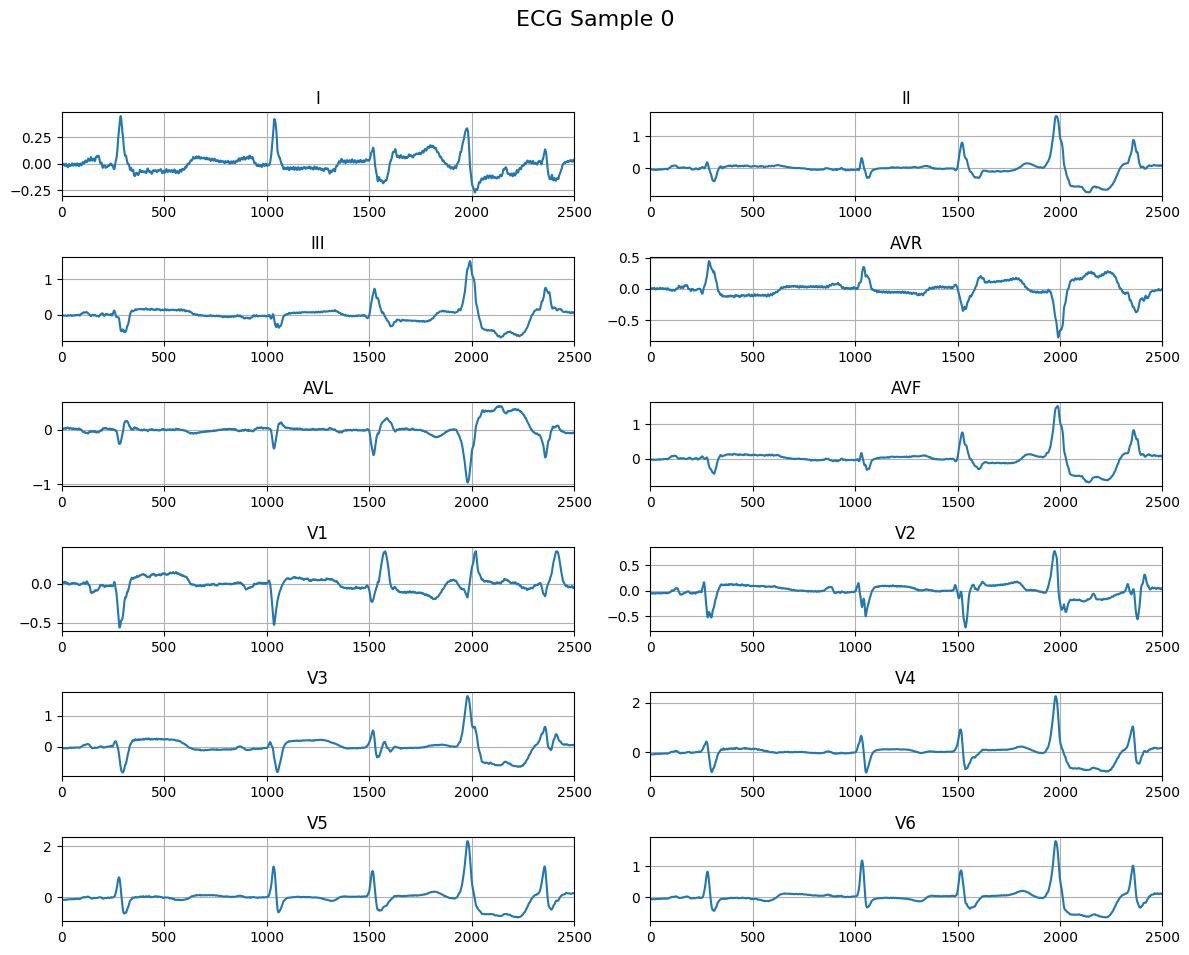

In [70]:
# Visualize the first ECG sample (12 leads)
sample_idx = 0
fig, axs = plt.subplots(6, 2, figsize=(12, 10))
fig.suptitle(f'ECG Sample {sample_idx}', fontsize=16)

for i, ax in enumerate(axs.flat):
    ax.plot(multi_lead_ecgs[sample_idx, i])
    ax.set_title(ecg_leads[i])
    ax.set_xlim([0, signal_length])
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [71]:
import pickle

# Load left samples from the big dataset
with open('data/df_signals_left.pkl', 'rb') as file:
    df_signals_left = pickle.load(file)

In [72]:
print("Small dataset columns:", df_small_meta.columns.tolist())
print("Left samples columns:", df_signals_left.columns.tolist())

Small dataset columns: ['Sex', 'HTA', 'Age', 'PVC_transition', 'SOO_chamber', 'Height', 'Weight', 'BMI', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'SOO', 'OTorigin', 'SOO_Chamber_Mapped', 'normalized_label', 'region_label']
Left samples columns: ['PatientID', 'SampleID', 'Structure', 'Leads', 'SOO', 'Sex', 'Age', 'PVC_transition', 'SOO_chamber', 'Height', 'Weight', 'BMI', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'OTorigin', 'SOO_Chamber_Mapped', 'normalized_label', 'region_label']


In [73]:
# Unify format before adding left samples to the small dataset
# Assign PatientID only if it doesn't already exist
if "PatientID" not in df_small_meta.columns:
    df_small_meta = df_small_meta.reset_index().rename(columns={"index": "PatientID"})

# Drop unneeded columns for left samples
df_left_meta = df_signals_left.drop(columns=['Leads', 'Structure', 'SampleID']) # Signals will be handled separately

# Concatenate metadata
df_combined_meta = pd.concat([df_small_meta, df_left_meta], ignore_index=True)

# Build ECG array for left samples from 'Leads'
ecg_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

left_ecgs = []
for _, row in df_signals_left.iterrows():
    leads_dict = row['Leads']
    ecg_sample = np.array([leads_dict[lead] for lead in ecg_leads])
    left_ecgs.append(ecg_sample)

left_ecgs = np.stack(left_ecgs)  # (n_left, 12, signal_length)

# Concatenate ECG arrays
combined_ecgs = np.concatenate([multi_lead_ecgs, left_ecgs], axis=0)

print("Combined metadata shape:", df_combined_meta.shape)
print("Combined ECG array shape:", combined_ecgs.shape)

Combined metadata shape: (5659, 20)
Combined ECG array shape: (5659, 12, 2500)


In [8]:
import scipy.signal as sp
from scipy.interpolate import interp1d

# Processes one sample ECG with all 12 leads
def preprocess_ecg_signal(ecg_signals, fs=1000, target_fs=250, high=0.5, low=100.0):
    """
    Preprocess a multi-lead ECG signal [timepoints, leads]:
    - Resample to target_fs
    - Bandpass filter between `high` and `low`
    """
    timepoints = ecg_signals.shape[0] # Initially, 2500
    new_timepoints = int(timepoints * target_fs / fs) # 625
    
    # Resample each lead using interpolation
    ecg_resampled = np.zeros((new_timepoints, ecg_signals.shape[1]))
    for lead in range(ecg_signals.shape[1]):
        f = interp1d(np.arange(timepoints), ecg_signals[:, lead]) # Interpolation function from original points
        ecg_resampled[:, lead] = f(np.linspace(0, timepoints - 1, new_timepoints)) # Create the new timeline

    # Apply high-pass filter (remove slow drifts below 0.5 Hz)
    b_high, a_high = sp.butter(2, high / (target_fs / 2), btype='high')
    ecg_filtered = sp.filtfilt(b_high, a_high, ecg_resampled, axis=0)

    # Apply low-pass filter (remove noise above 100 Hz)
    b_low, a_low = sp.butter(2, low / (target_fs / 2), btype='low')
    ecg_filtered = sp.filtfilt(b_low, a_low, ecg_filtered, axis=0)

    return ecg_filtered # Return the signal with shape [625, 12]

In [9]:
def align_to_r_peak(ecg_filtered, fs=250):
    """
    Align ECG segment around R peak detected in the second second (samples 250–500).
    Returns a centered window of 1.25s (312 samples) around the R peak.
    """
    lead_for_r = 1  # Lead II is commonly used for R-peak detection
    signal = ecg_filtered[:, lead_for_r]
    
    # Focus on 1s to 2s segment
    window_start, window_end = int(1 * fs), int(2 * fs)
    segment = signal[window_start:window_end]
    
    # Find R peak in that window
    r_peak_relative = np.argmax(segment)
    r_peak_absolute = window_start + r_peak_relative

    # Center a 312-sample window on R peak
    half_window = 156
    start_idx = max(0, r_peak_absolute - half_window)
    end_idx = start_idx + 312

    # If window is beyond bounds, pad accordingly
    if end_idx > ecg_filtered.shape[0]:
        pad_len = end_idx - ecg_filtered.shape[0]
        padded = np.pad(ecg_filtered, ((0, pad_len), (0, 0)), mode='constant')
        segment_aligned = padded[start_idx:end_idx]
    else:
        segment_aligned = ecg_filtered[start_idx:end_idx]

    return segment_aligned

In [ ]:
preprocessed_ecgs = []
for i in range(multi_lead_ecgs.shape[0]):
    signal_raw = multi_lead_ecgs[i].T  # shape becomes [2500, 12]
    processed = preprocess_ecg_signal(signal_raw)  # shape [625, 12]
    aligned = align_to_r_peak(processed)  # shape [312, 12]
    preprocessed_ecgs.append(aligned)

preprocessed_ecgs = np.stack(preprocessed_ecgs)  # shape [n_samples, 312, 12]
print("All signals aligned to R peak. Final shape:", preprocessed_ecgs.shape)

In [ ]:
# Number of samples to plot
n_samples_to_plot = 6
lead_index = 1  # Lead II
lead_name = 'II'

# Randomly select sample indices
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(preprocessed_ecgs.shape[0], n_samples_to_plot, replace=False)

# Create subplots
fig, axs = plt.subplots(n_samples_to_plot, 1, figsize=(12, 2.5 * n_samples_to_plot), sharex=True)

for i, idx in enumerate(sample_indices):
    axs[i].plot(preprocessed_ecgs[idx, :, lead_index], label=f'Sample {idx}')
    axs[i].axvline(x=156, color='r', linestyle='--', label='Center (R-peak)')
    axs[i].set_ylabel("Amplitude")
    axs[i].grid(True)
    axs[i].legend(loc='upper right')
    axs[i].set_title(f"Aligned ECG - Sample {idx} (Lead {lead_name})")

axs[-1].set_xlabel("Sample Index (Aligned Window)")
plt.tight_layout()
plt.show()

In [ ]:
# Compare the raw signal vs. aligned signal for a given sample
sample_idx = i  # make sure 'i' is defined or choose another valid sample index

leads_to_plot = ['I', 'AVR', 'V2']
lead_indices = [ecg_leads.index(lead) for lead in leads_to_plot]

# Raw signal: shape [12, 2500]
raw_signal = multi_lead_ecgs[sample_idx]

# Aligned signal (after preprocessing and R-peak alignment): shape [312, 12]
aligned_signal = preprocessed_ecgs[sample_idx].T  # shape [12, 312]

# Time axes
t_raw = np.linspace(0, 2.5, raw_signal.shape[1])              # 2500 samples at 1000 Hz
t_aligned = np.linspace(0, 1.25, aligned_signal.shape[1])     # 312 samples at 250 Hz

plt.figure(figsize=(15, 8))

for k, lead_idx in enumerate(lead_indices):
    plt.subplot(len(lead_indices), 1, k+1)
    
    plt.plot(t_raw, raw_signal[lead_idx], label='Raw (1000Hz)', alpha=0.6)
    plt.plot(t_aligned, aligned_signal[lead_idx], label='Aligned (250Hz)', alpha=0.9)
    
    plt.title(f"Lead {ecg_leads[lead_idx]} - Sample {sample_idx}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

There are many missing values in different columns, so we must decide how to handle them. Since no columns have more than 40% missing values, we decided to impute them.

In [17]:
# Impute numerical columns (median)
numeric_columns = ["Age", "Height", "Weight", "BMI"]
df_clean[numeric_columns] = df_clean[numeric_columns].fillna(df_clean[numeric_columns].median())

# Impute categorical columns (mode)
categorical_columns = ["Sex", "PVC_transition", "HTA", "DM", "DLP", "Smoker", "COPD", "Sleep_apnea", "OTorigin"]
df_clean[categorical_columns] = df_clean[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))

# Map labels to numeric values
df_clean["label"] = df_clean["normalized_label"].map({"Left": 0, "Right": 1})

In [ ]:
print(df_clean.info())
df_clean.head(10)

In [19]:
# Extract valid indices
valid_indices = df_clean.index.tolist()
labels = df_clean["label"].values

# Align ECG signals with df_clean
X = [preprocessed_ecgs[i] for i in valid_indices]
y = labels

In [ ]:
# Split into train/test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, valid_indices, stratify=y, test_size=0.2, random_state=42)

# Convert X_train and X_test to NumPy arrays
X_train = np.stack(X_train)
X_test = np.stack(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Check results
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# Class counts
left_train = np.sum(y_train == 0)
right_train = np.sum(y_train == 1)

# Print counts
print("Training Set:")
print("  Left (0):", left_train)
print("  Right (1):", right_train)

# Bar positions
x = np.arange(2)  # Two bars: Left and Right
width = 0.5

plt.figure(figsize=(6, 5))
plt.bar(x[0], left_train, width=width, label='Left (0)', color='red', edgecolor='black')
plt.bar(x[1], right_train, width=width, label='Right (1)', color='blue', edgecolor='black')

plt.xticks(x, ['Left (0)', 'Right (1)'])
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
import torch 

# Load pretrained SAK models
model_dir = "data/modelos"
models = [torch.load(f"{model_dir}/model.{i+1}") for i in range(5)]

In [23]:
import numpy as np
import torch
import skimage.util
import math
from typing import List

def predict_ecg(
    ecg: np.ndarray,
    fs: int = 250,
    model: List[torch.nn.Module] = None,
    window_size: int = 2048,
    stride: int = 256,
    threshold_ensemble: float = 0.5,
    thr_dice: float = 0.9,
    ptg_voting: float = 0.5,
    batch_size: int = 16
) -> np.ndarray:
    """
    Predicts P, QRS, and T masks for a given ECG signal using an ensemble of models.

    Args:
        ecg (np.ndarray): ECG signal of shape (T, L) where T is time, L is leads.
        fs (int): Sampling frequency (default 250).
        model (list): List of PyTorch models (each predicting sigmoid mask for 3 classes).
        window_size (int): Window size in samples for model input.
        stride (int): Stride between windows.
        threshold_ensemble (float): Threshold proportion of models that must agree on a point.
        thr_dice (float): Threshold for each model’s probability output to count as a “positive”.
        ptg_voting (float): Final voting threshold on normalized votes per timepoint.
        batch_size (int): Batch size for model prediction.

    Returns:
        full_mask (np.ndarray): Binary mask of shape (3, T) for P, QRS, and T waves.
    """
    if ecg.shape[0] < 50:
        raise ValueError(f"Signal too short for segmentation: {ecg.shape}")

    ecg = np.copy(ecg)
    if ecg.ndim == 2 and ecg.shape[0] < ecg.shape[1]:
        ecg = ecg.T
    ecg = ecg[:, :12]

    N = ecg.shape[0]

    # Pad to multiple of window size
    if N < window_size:
        pad = math.ceil(N / window_size) * window_size - N
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')
    
    remainder = (ecg.shape[0] - window_size) % stride
    if remainder != 0:
        pad = stride - remainder
        ecg = np.pad(ecg, ((0, pad), (0, 0)), mode='edge')

    # Windowing
    windowed = skimage.util.view_as_windows(ecg, (window_size, ecg.shape[1]), step=(stride, 1))
    windowed = windowed[:, 0, :, :]  # (n_windows, 2048, 12)
    windowed = np.swapaxes(windowed, 1, 2)  # (n_windows, 12, 2048)

    # Model expects 1 channel per lead per window, so let's adjust the shape
    windowed = windowed.reshape(-1, 1, window_size)  # (n_windows * 12, 1, 2048)

    # Prediction
    mask = np.zeros((windowed.shape[0], 3, window_size), dtype=float)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if model is None or len(model) == 0:
        raise ValueError("No models provided for prediction.")

    # Set models to evaluation mode
    for m in model:
        m.eval()

    with torch.no_grad():
        for m in model:
            m = m.to(device)
            for i in range(0, windowed.shape[0], batch_size):
                inputs = {"x": torch.tensor(windowed[i:i+batch_size]).float().to(device)}
                output = m(inputs)
                
                # Handle model outputs based on expected type
                if isinstance(output, dict):
                    outputs = output["sigmoid"].cpu().numpy()
                else:
                    outputs = torch.sigmoid(output).cpu().numpy()
                
                mask[i:i+batch_size] += outputs > thr_dice

        # Threshold based on ensemble agreement
        mask = mask >= len(model) * threshold_ensemble

    # Reconstruct full mask
    full_len = (mask.shape[0] - 1) * stride + window_size
    full_mask = np.zeros((3, full_len))
    counter = np.zeros(full_len)

    for i in range(mask.shape[0]):
        start = i * stride
        full_mask[:, start:start+window_size] += mask[i]
        counter[start:start+window_size] += 1

    # Avoid division by zero
    counter[counter == 0] = 1
    full_mask = (full_mask / counter) > ptg_voting

    # Truncate to original length
    full_mask = full_mask[:, :N]

    return full_mask

In [24]:
def extract_morph_features(
    signal: np.ndarray,
    mask: np.ndarray,
    fs: int = 250
) -> dict:
    """
    Extracts R/S amplitude, ratio, QRS duration, and T polarity from a single lead.

    Args:
        signal (np.ndarray): ECG signal for one lead (T,) or (T, 1).
        mask (np.ndarray): Binary segmentation mask of shape (3, T).
        fs (int): Sampling frequency in Hz.

    Returns:
        dict: Extracted features.
    """
    features = {}
    if signal.ndim == 2:
        signal = signal[:, 0]
    if signal.shape[0] < 10 or mask.shape != (3, signal.shape[0]):
        raise ValueError("Malformed signal or mask")

    r_peak = np.max(signal)
    s_trough = np.min(signal)
    r_s_ratio = r_peak / abs(s_trough) if s_trough != 0 else 0

    qrs_indices = np.where(mask[1])[0]
    qrs_dur = (qrs_indices[-1] - qrs_indices[0]) / fs * 1000 if len(qrs_indices) > 1 else 0

    t_indices = np.where(mask[2])[0]
    if len(t_indices) > 3:
        t_mean = np.mean(signal[t_indices])
        polarity = 1 if t_mean > 0.02 else (-1 if t_mean < -0.02 else 0)
    else:
        polarity = 0

    features["r_amp"] = r_peak
    features["s_amp"] = s_trough
    features["r_s_ratio"] = r_s_ratio
    features["qrs_dur"] = qrs_dur
    features["t_polarity"] = polarity

    return features

In [25]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from typing import List

def extract_all_features(
    X_data: np.ndarray,
    y_data: np.ndarray,  # Patient ID or unique identifier
    models: List[torch.nn.Module],
    fs: int = 250
) -> pd.DataFrame:
    """
    Extract morphological features for all ECGs and all leads.

    Args:
        X_data (np.ndarray): ECGs of shape (N, T, L)
        y_data (np.ndarray): Patient IDs or another identifier (aligned with X_data)
        models (List[torch.nn.Module]): Ensemble of PyTorch models
        fs (int): Sampling frequency

    Returns:
        pd.DataFrame: Feature dataframe with one row per ECG, including patient_id
    """
    feature_rows = []

    for i in tqdm(range(len(X_data)), desc="Extracting features"):
        ecg = X_data[i]
        patient_id = y_data[i]  # This corresponds to the patient ID or unique identifier

        try:
            # Predict mask or segmentation for the ECG (assuming you have a `predict_ecg` function)
            mask = predict_ecg(ecg, fs=fs, model=models)

            row = {"patient_id": patient_id}  # Start row with the patient ID

            for lead_idx in range(ecg.shape[1]):
                lead_signal = ecg[:, lead_idx]
                lead_mask = mask.copy()

                try:
                    features = extract_morph_features(lead_signal, lead_mask, fs=fs)
                    # Extract features for the current lead and add them to the row
                    for key, val in features.items():
                        row[f"lead{lead_idx+1}_{key}"] = val
                except Exception as e:
                    print(f"Feature extraction failed on sample {i}, lead {lead_idx}: {e}")
                    # If feature extraction fails, fill with NaN
                    for key in ["r_amp", "s_amp", "r_s_ratio", "qrs_dur", "t_polarity"]:
                        row[f"lead{lead_idx+1}_{key}"] = np.nan

            feature_rows.append(row)

        except Exception as e:
            print(f"Segmentation failed on sample {i}: {e}")
            continue

    # Convert the list of rows into a DataFrame
    feature_df = pd.DataFrame(feature_rows)

    return feature_df

In [ ]:
# Extract features for the training set
df_train_features = extract_all_features(X_train, train_idx, models)

# Extract features for the test set
df_test_features = extract_all_features(X_test, test_idx, models)

In [ ]:
df_train_features.head()

In [ ]:
df_train_features.info()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

X_train_feat = df_train_features.drop(columns=['patient_id'])
y_train_labels = y_train

# Apply ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train_feat, y_train_labels)

# Retrieve selected feature names
selected_features = X_train_feat.columns[selector.get_support()]
print("Selected features:", selected_features)

In [ ]:
df_clean.info()

In [31]:
df_clean['patient_id'] = df_clean.index

In [ ]:
df_clean.head()

In [ ]:
!pip install seaborn

In [ ]:
!pip install shap

In [35]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
# Merge df_train_features with df_clean on 'patient_id'
df_train_merged = pd.merge(df_train_features, df_clean, on='patient_id', how='left')

# Exclude 'SOO' and 'normalized_label' from the categorical columns list for encoding
categorical_cols = ['Sex', 'HTA', 'PVC_transition', 'SOO_chamber', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea']

# Encode categorical columns using one-hot encoding
df_train_merged = pd.get_dummies(df_train_merged, columns=categorical_cols, drop_first=True)

# Now df_train_merged contains both features and demographic data, ready for model training
# Separate features and labels
X_train_merged = df_train_merged.drop(columns=['patient_id', 'label', 'SOO', 'normalized_label'])
y_train_merged = df_train_merged['label']

In [ ]:
X_train_merged.info()

In [38]:
# Do the same for the test set
df_test_merged = pd.merge(df_test_features, df_clean, on='patient_id', how='left')

# Encode categorical columns using one-hot encoding for the test set
df_test_merged = pd.get_dummies(df_test_merged, columns=categorical_cols, drop_first=True)

# Now df_test_merged contains both features and demographic data, ready for model training
# Separate features for the test set
X_test_merged = df_test_merged.drop(columns=['patient_id', 'label', 'SOO', 'normalized_label'])

# Get the true labels for the test set directly from df_clean, based on patient_id
y_test = df_clean.loc[df_clean['patient_id'].isin(df_test_merged['patient_id']), 'label']

In [ ]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_merged, y_train_merged)

# Make predictions
y_pred = rf_model.predict(X_test_merged)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

# Evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the hyperparameter grid to search through (without 'max_features')
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples required at each leaf node
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_merged, y_train_merged)

# Get the best parameters from GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_rf_model.predict(X_test_merged)

# Evaluate performance of the best model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))